# Introduction

Experiment with MLflow from this [Video Tutorial](https://www.youtube.com/watch?v=WbicniUy_u0).

In [1]:
# Import Standard Libraries
import mlflow
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('MLflow Version: ', mlflow.version.VERSION)

MLflow Version:  2.11.1


# Basic Code

In [3]:
# Set experiment
mlflow.set_experiment('basic_code')

<Experiment: artifact_location='file:///Users/s.porreca/Projects/cheat_sheets/machine_learning/mlflow/mlruns/176222180829175951', creation_time=1679261939948, experiment_id='176222180829175951', last_update_time=1679261939948, lifecycle_stage='active', name='basic_code', tags={}>

In [4]:
# Start MLflow Run
with mlflow.start_run(run_name='Run Name {}'.format(np.random.randint(1, 100))) as mlflow_run:
    
    # Show run ID
    print('MLflow Run: ', mlflow_run.info.run_uuid)
    
    # Show Run Name
    print('MLflow Run: ', mlflow_run.info.run_name)
    
    # Set a Run tag
    mlflow.set_tag('tag', 'Tag {}'.format(np.random.randint(1, 100)))
    
    # Log a Parameter
    mlflow.log_param('parameter_1', np.random.randint(1, 100))
    
    # Log a Metric
    mlflow.log_metric('accuracy', np.random.randint(0, 100))
    
    mlflow.end_run()

MLflow Run:  917c1cac2bcc4c2492f50d9e232ad5ad
MLflow Run:  Run Name 73


# Regression Example

## Read & Prepare Data

In [2]:
# Read data
data = pd.read_csv('./../../data/books_sold_train.csv', 
                   parse_dates=['date'], 
                   index_col=0)

In [3]:
data.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [4]:
# Engineering the date
data['day'] = data['date'].dt.day

In [5]:
# Define features and labell
numerical_features = ['day']

categorical_features = ['product', 
                        'store', 
                        'country']

labels = ['num_sold']

In [6]:
# Numerical features pipeline
numerical_features_pipeline = Pipeline(steps=[
    ('numerical_scaler', StandardScaler())
])

In [7]:
# Categorical features pipeline
categorical_features_pipeline = Pipeline(steps=[
    ('categorical_one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
# Bunlde data preprocessing steps
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_preprocessing', numerical_features_pipeline, numerical_features),
        ('categorical_preprocessing', categorical_features_pipeline, categorical_features)
    ])

In [9]:
# Define X and y for the training set
X = data[numerical_features + categorical_features]
y = data[labels]

In [10]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## MLflow Run

In [14]:
# Define experiment name
mlflow_experiment_name = 'Regression Example 22/03/2024'

# Create experiment or retrieve already existing experiment
try:
    mlflow_experiment_id = mlflow.create_experiment(name=mlflow_experiment_name,
                                                    tags={
                                                        'version': 'v.0.1.1',
                                                        'priority': 1
                                                    })
except Exception as e:
    mlflow_experiment_id = mlflow.get_experiment_by_name(mlflow_experiment_name).experiment_id

In [15]:
# Define a folder name for the EDA Plots
eda_plots_folder = 'eda_plots'

# Create an 'eda_plots' folder
if eda_plots_folder not in os.listdir():
    os.mkdir(eda_plots_folder)

### ElasticNet

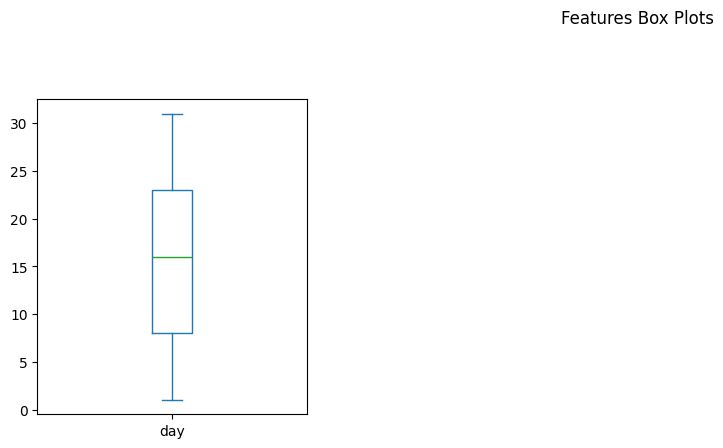

In [16]:
# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='ElasticNet_20240322'):
    
    # Create the Features Box Plots
    X_train.plot(kind='box', 
                 subplots=True, 
                 layout=(2, 4), 
                 figsize=(16, 9), 
                 title='Features Box Plots')
    
    # Save the plot
    plt.savefig('./{}/features_box_plots.png'.format(eda_plots_folder))
    
    # Log the eda_plots_folder and tracking it
    mlflow.log_artifacts(eda_plots_folder)
    
    # Define Hyperparameters
    alpha, l1_ratio = 0.06, 0.45
    
    # Define the Model
    elastic_net_model = ElasticNet(alpha=alpha, 
                                   l1_ratio=l1_ratio, 
                                   random_state=42)
    
    # Define the pipeline
    pipe_en = Pipeline([
        ('date_preprocessing', data_preprocessor),
        ('elastic_net', elastic_net_model)
    ])
    
    # Fit the estimator
    pipe_en.fit(X_train, 
                y_train)
    
    # Predictions
    predictions_en = pipe_en.predict(X_test)
    
    # Compute metrics
    rmse_en = mean_squared_error(y_test, predictions_en)
    mae_en = mean_absolute_error(y_test, predictions_en)
    
    # Log model's hyperparameters
    mlflow.log_params({'alpha': alpha,
                       'l1_ratio': l1_ratio})
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_en, 
                        'MAE': mae_en})
    
    # Log the model
    mlflow.sklearn.log_model(pipe_en, 'ElasticNet')